In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ase.build import graphene, bulk
from ase.io import read

from abtem import show_atoms
from abtem.structures import orthogonalize_cell

def pretty_print_transform(transform):
    print('euler angles (degrees): \t x = {:.3f}, \t y = {:.3f}, \t z = {:.3f}'.format(*transform[0] / np.pi * 180))
    print('normal strains (percent): \t x = {:.3f}, \t y = {:.3f}, \t z = {:.3f}'.format(*(transform[1] - 1) * 100))
    print('shear strains (percent): \t xy = {:.3f}, \t xz = {:.3f}, \t xz = {:.3f}'.format(*(transform[2]) * 100))

# Orthogonal periodic supercells

The multislice algorithm requires an orthogonal periodic atomic structure as its input. However, taking any arbitrary structure and making it periodic and orthogonal is not as trivial as one might think. This tutorial provides some intuition into the problem and introduces a tool in abTEM's `structures` module for solving it. If you are not interested in background information you can skip to the section named "The `orthogonalize_cell` function".

## Making 2D cells orthogonal

### Hexagonal cells

We will start building our intuition by first considering the special case of hexagonal structures. Below we create a minimal unit cell of graphene and show a corresponding repeated supercell.

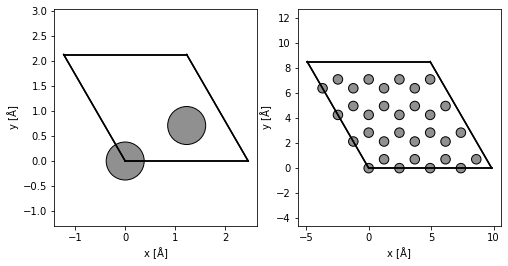

In [2]:
gra = graphene(vacuum=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
show_atoms(gra, ax=ax1)
show_atoms(gra * (4, 4, 1), ax=ax2);

The ASE atoms object's `cell` is a three-dimensional array, so that e.g. the first lattice vector can be addressed with the index 0, and the `x`-component of the second lattice vector with the indices 1,0:

In [3]:
print(gra.cell[0])
print(gra.cell[1,0])

[2.46 0.   0.  ]
-1.23


The hexagonal cell is almost orthogonal. We just need to somehow make the $x$-component of the second (or $b$) lattice vector zero. Let's first define and display the lattice vectors.

In [4]:
a, b, c = gra.cell

print('a = ({:.3f}, {:.3f}, {:.3f})'.format(*a))
print('b = ({:.3f}, {:.3f}, {:.3f})'.format(*b))
print('c = ({:.3f}, {:.3f}, {:.3f})'.format(*c))

a = (2.460, 0.000, 0.000)
b = (-1.230, 2.130, 0.000)
c = (0.000, -0.000, 4.000)


Now, let's see what happens if we make this change by just changing the $x$-component of $b$.

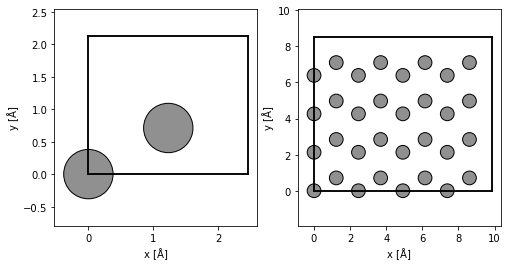

In [5]:
wrong_gra = gra.copy()

cell = wrong_gra.cell.copy()
cell[1]= [0., b[1], 0.]

wrong_gra.set_cell(cell)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
show_atoms(wrong_gra, ax=ax1);
show_atoms(wrong_gra * (4, 4, 1), ax=ax2);

The result is a cell that is obviously orthogonal, but when it is repeated, it no longer tiles space to produce the graphene structure.

To preserve periodicity, we must create a new lattice vector by combining an integer number of the old lattice vectors. Let's call the new lattice vector $b'$, and observe that for this structure, we should only combine the $a$ and $b$ vectors, since the $c$ vector only has a $z$-component. Hence, we can write, $b'$, as

$$
b' = k \cdot a + l \cdot b ,
$$

where $k$ and $m$ are integers. To make the structure orthogonal, the $x$-component of $b'$ has to be zero:

$$
b_x' = 0
$$

Combining these conditions and using the lattice parameter of graphene we get:

$$
l = -k \frac{a_x}{b_x} = k \frac{2.46}{1.23} = 2 k
$$

If we further constraint $b_y$ to be non-zero and wish to have the smallest possible new unit cell, this leads to the solution $k = 1$ and $l = 2$:

$$
b' = a + 2 b
$$

Below we create a new graphene structure with the lattice vectors $a$, $b'$ and $c$. Note that to multiply the $b$ lattice vector by two, we instead repeat the atoms object in that direction, this fills in the additional atoms needed for the larger unit cell. We also make use of the `wrap` method to map atoms from outside the cell back into it.

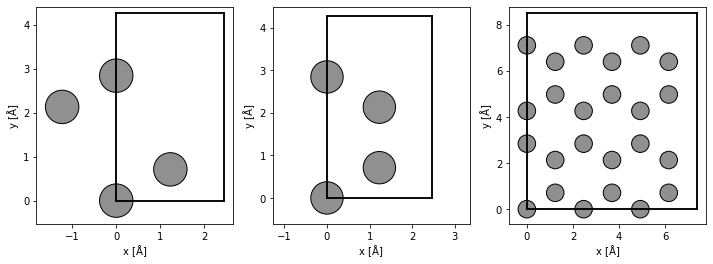

In [6]:
orthogonal_gra = gra * (1, 2, 1) # multiply the b lattice vector by 2 
orthogonal_gra.cell[1] += a # add the a lattice vector

wrapped_orthogonal_gra = orthogonal_gra.copy()
wrapped_orthogonal_gra.wrap() 
# "wrap" the atoms outside the cell back into the cell (not strictly necessary due to periodic boundaries)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
show_atoms(orthogonal_gra, ax=ax1)
show_atoms(wrapped_orthogonal_gra, ax=ax2)
show_atoms(wrapped_orthogonal_gra * (3, 2, 1), ax=ax3);

### Monoclinic cells

The approach for hexagonal structures works in general for other 2D structures. However, the minimum values of $k$ and $l$ are dependent on the ratio of the lattice vectors. This ratio can take on any value, e.g. if the ratio is $-5 / 3$ then $k = 3$ and $l=5$ is the smallest solution.

This may be problematic in some cases. If the structure is very close to orthogonal, the ratio and hence the number of repetitions can become huge, requiring prohibitive computational resources when we try to use the atoms in a simulation. Moreover, if the ratio is irrational there will not even be an integer solution.

The latter is not a serious problem in practice, as we can always apply a tiny amount of strain to the unit cell, such that the ratio is a close rational approximation of the actual ratio.

As an example, if the ratio is $\pi$, we can slightly strain the structure such the the ratio is $22 / 7$

$$
l = k \pi \approx k \frac{22}{7}
$$

to get the solution

$$
k = 7, \quad l = 22 .
$$

Next, we will work through an example for the monoclinic structure of titanate, which requires applying strain.

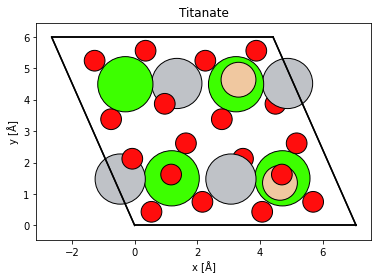

In [7]:
titanate = read('data/titanate.cif')
show_atoms(titanate, title='Titanate');

The ratio of the $x$-components of the $a$ and $b$ lattice vectors is:

In [8]:
print(f'Titanate lattice vector ratio: {(titanate.cell[0,0] / titanate.cell[1,0]):.5f}')

Titanate lattice vector ratio: -2.67002


We use the rational approximation $-2.67 \approx -2.5 = -5 / 2$, and hence need to apply a strain to the unit cell such that $a_x / b_x = 2.5$. We can use the `set_cell` method to apply strain to the cell and the atoms. Finally, we repeat the cell and set $b_x = 0$, as we did for the graphene example. 

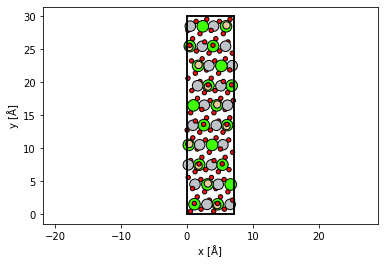

In [9]:
orthogonal_titanate = titanate.copy()

new_cell = orthogonal_titanate.cell.copy()
new_cell[1, 0] = -orthogonal_titanate.cell[0, 0] * (2/5)

orthogonal_titanate.set_cell(new_cell, scale_atoms=True)

orthogonal_titanate *= (1, 5, 1)
orthogonal_titanate.cell[1, 0] = 0.

orthogonal_titanate.wrap()

show_atoms(orthogonal_titanate);

In this case the final structure is not exactly identical to the input due to the applied strain. However, we can get closer by using a better rational approximation of $2.67$. The next rational approximation only requires slightly larger numbers, $8 / 3 \approx 2.6667$, and provides a significant improvement. The following approximation after that is however $139/52 \approx 2.6731$, which would require a huge unit cell for very little additional benefit.

## The `orthogonalize_cell` function

The `orthogonalize_cell` function automates the steps we took above for arbitrary cells in 3D. It will make a unit cell orthogonal by repeating it until the lattice vectors align with the three principal Cartesian directions. The maximum number of allowed repetitions may be given using the `max_repetitions` argument.

If an exactly orthogonal cell can be created using a smaller number of repetitions, the solution with the smallest number of repetitions will be returned (a larger cell can always be created as desired by multiplying the `atoms` object).

If it is not possible to make the structure orthogonal within the given `max_repetitions`, the function will return the smallest structure among the most orthogonal structures. That structure will be forced to become orthogonal by applying an affine transformation to the cell and the atoms, i.e. the crystal will be slightly strained and/or rotated.

The 2D examples introduced above are easily solved. For titanate we restrict the repetitions to 5, hence the same strained titanate structure is obtained as above.

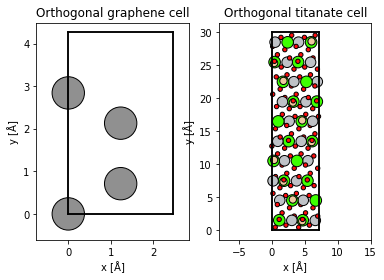

In [10]:
orthogonal_gra = orthogonalize_cell(gra)

orthogonal_titanate = orthogonalize_cell(titanate, max_repetitions=5)

fig, (ax1, ax2) = plt.subplots(1, 2)

show_atoms(orthogonal_gra, ax=ax1, title='Orthogonal graphene cell')
show_atoms(orthogonal_titanate, ax=ax2, title='Orthogonal titanate cell');

The function also works on arbitrary 3D crystals. We first consider the example of face-centered cubic gold. The `bulk` function from ASE creates the minimal unit cell by default, which `orthogonalize_cell` will convert to a conventional unit cell.

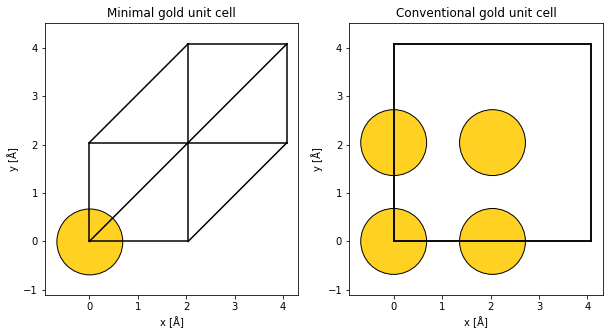

In [11]:
gold = bulk('Au')

orthogonal_gold, gold_transform = orthogonalize_cell(gold, return_transform=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
show_atoms(gold, ax=ax1, title='Minimal gold unit cell')
show_atoms(orthogonal_gold, ax=ax2, title='Conventional gold unit cell');

By setting `return_transform=True`, the affine transformation required to make the repeated cell orthgonal is returned. The transform consists of the three Euler angles of an extrinsic $x$ then $y$ then $z$ rotation; a normal strain for the principal axes $x$, $y$ and $z$; and a shear strain for $xy$, $xz$ and $yz$.

In the case of face-centered cubic gold, we know that it is possible to create an orthogonal cell without applying strain, hence, as expected no affine transformation was required (for viewing the structure along the `[1,0,0]` zone axis).

In [12]:
pretty_print_transform(gold_transform)

euler angles (degrees): 	 x = 0.000, 	 y = -0.000, 	 z = 0.000
normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = 0.000
shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000


Next we try the same for a crystal that does not have a perfectly equivalent orthogonal cell.

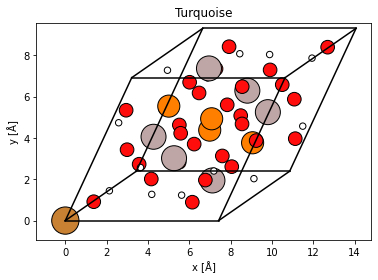

In [13]:
turquoise = read('data/turquoise.cif')

show_atoms(turquoise, title='Turquoise');

In [14]:
print('Turquoise cell angles:', turquoise.cell.angles())

Turquoise cell angles: [68.61 69.71 65.08]


Applying `orthogonalize_cell` with `max_repetitions = 6` we obtain the result below.

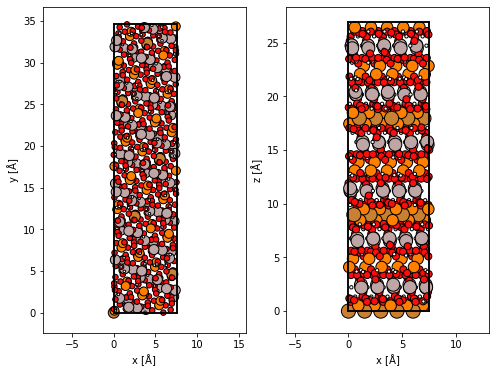

In [15]:
orthogonal_turquoise, turquoise_transform = orthogonalize_cell(turquoise, max_repetitions=6, return_transform=True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,6))
show_atoms(orthogonal_turquoise, ax=ax1)
show_atoms(orthogonal_turquoise, ax=ax2, plane='xz');

In this case, a small transformation was necessary, for example a normal strain in $x$ of $1.5 \%$.

In [16]:
pretty_print_transform(turquoise_transform)

euler angles (degrees): 	 x = -0.501, 	 y = -0.718, 	 z = -2.027
normal strains (percent): 	 x = 1.519, 	 y = -0.056, 	 z = -0.012
shear strains (percent): 	 xy = -3.496, 	 xz = 1.234, 	 xz = -0.875


## Crystal directions

Even if we have an orthogonal structure with a given zone axis aligned with the `z` direction, we may need to perform a transformation to obtain a cell for another desired direction. The `orthogonalize_cell` function respects the orientation of the input crystal, hence we can rotate the crystal and then use the function to get a cell with lattice vectors pointing along the principal directions.

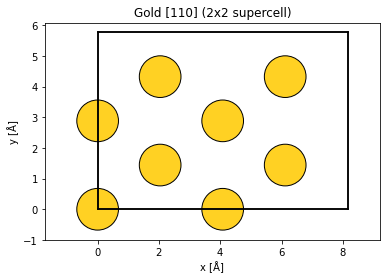

In [17]:
gold_110 = gold.copy()

gold_110.rotate(45, 'x', rotate_cell=True)

gold_110 = orthogonalize_cell(gold_110, max_repetitions=5)

show_atoms(gold_110 * (2, 2, 1), title='Gold [110] (2x2 supercell)');

As an alternative to rotating the structure, the `surface`  function from ASE can create an atomic structure for a given zone axis. Unlike `orthogonalize_cell`, this function always finds the minimal structure, which may not be orthogonal.

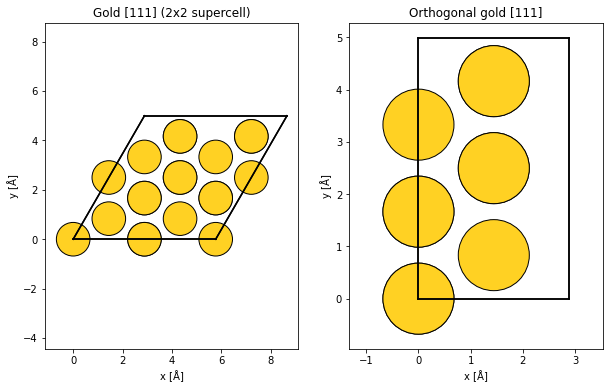

In [18]:
from ase.build import surface

gold_111 = surface(gold, (1, 1, 1), layers=5, periodic=True) # 111 direction aligned with z but not orthogonal

gold_111_orthogonal = orthogonalize_cell(gold_111)

_, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
show_atoms(gold_111 * (2, 2, 1), title='Gold [111] (2x2 supercell)', ax=ax1)
show_atoms(gold_111_orthogonal, title='Orthogonal gold [111]', ax=ax2);

Small rotations away from a low-order zone axis may require a very large number of repetitions, or alternatively some repetions and a transformation. Here we rotate the gold structure 3 degrees away from the $[100]$ zone axis with `max_repetitions = 10`.

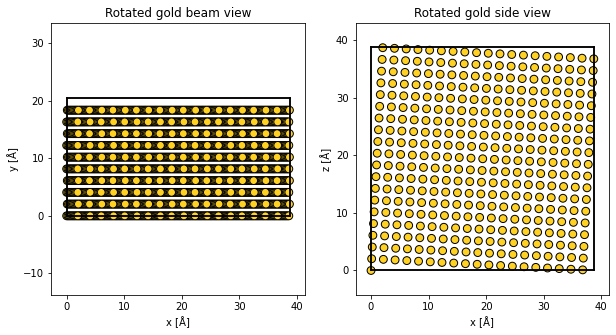

In [19]:
desired_rotation = 3

rotated_gold = gold.copy()
rotated_gold.rotate(desired_rotation, 'y', rotate_cell=True)

rotated_gold, rotated_gold_transform = orthogonalize_cell(rotated_gold, max_repetitions=10, return_transform=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
show_atoms(rotated_gold * (1, 5, 1), ax=ax1, title='Rotated gold beam view')
show_atoms(rotated_gold, ax=ax2, plane='xz', title='Rotated gold side view');

Inspecting the transformations we see that a rotation of $-0.013$ degrees was required. This means that we were not able to obtain an orthogonal structure rotated by exactly $3$ degrees (for this value of `max_repetitions`), instead we got a structure rotated by $2.987$ degrees.

In [20]:
pretty_print_transform(rotated_gold_transform)

euler angles (degrees): 	 x = 0.000, 	 y = -0.013, 	 z = -0.000
normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = -0.000
shear strains (percent): 	 xy = -0.000, 	 xz = -0.000, 	 xz = 0.000


## Advanced use case: twisted bilayer graphene

Twisted bilayer graphene is an example of a system of great research interest, where creating orthogonal commensurate unit cells is highly non-trivial. Let's explore how this can be done using `abTEM`'s `orthogonalize_cell` function.

Let's start with taking two orthogonal graphene unit cells, rotating one of them by half of our desired relative rotation of 3.15 degrees. We studied an equivalent structure with `GPAW` and `abTEM` in a recent publication (https://onlinelibrary.wiley.com/doi/10.1002/smll.202100388).

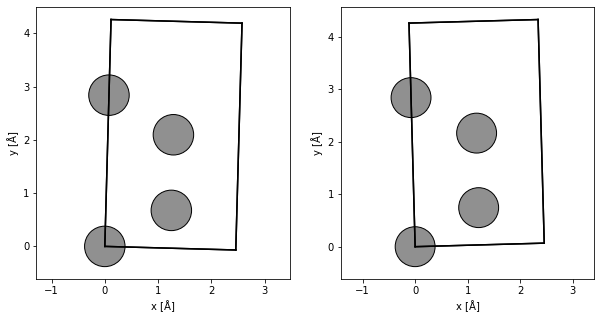

In [21]:
gra1 = wrapped_orthogonal_gra.copy()
gra2 = wrapped_orthogonal_gra.copy()

desired_rotation = 3.15

gra1.rotate(-desired_rotation / 2, 'z', rotate_cell=True)
gra1.wrap()

gra2.rotate(desired_rotation / 2, 'z', rotate_cell=True)
gra2.wrap()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
show_atoms(gra1, ax=ax1)
show_atoms(gra2, ax=ax2);

We need to make each of the rotated cells orthogonal, to avoid adding strain we set `max_repetitions=70`.

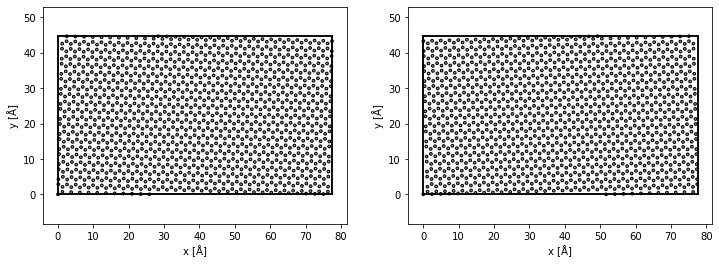

In [22]:
max_repetitions = 70

gra1_orthogonal, gra1_transform = orthogonalize_cell(gra1, max_repetitions=max_repetitions, return_transform=True)
gra2_orthogonal, gra2_transform = orthogonalize_cell(gra2, max_repetitions=max_repetitions, return_transform=True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

show_atoms(gra1_orthogonal, ax=ax1)
show_atoms(gra2_orthogonal, ax=ax2);

In [23]:
pretty_print_transform(gra1_transform)

euler angles (degrees): 	 x = 0.000, 	 y = -0.000, 	 z = -0.000
normal strains (percent): 	 x = -0.000, 	 y = 0.000, 	 z = 0.000
shear strains (percent): 	 xy = -0.000, 	 xz = 0.000, 	 xz = 0.000


We translate one of the layers in `z` by the van der Waals distance, and combine them into a bilayer that we center into the middle of the cell with 4 Å of vacuum.

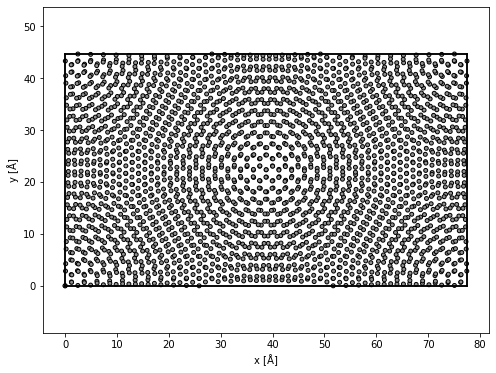

In [24]:
gra_bilayer = gra1_orthogonal.copy()

gra_bilayer.translate((0, 0, 3.55))

gra_bilayer = gra_bilayer + gra2_orthogonal

gra_bilayer.center(axis=2, vacuum=4)

show_atoms(gra_bilayer, figsize=(8,6));